In [1]:
import torch
import os
import numpy as np
from hmc_u1 import HMC_U1
from hmc_u1_ft import HMC_U1_FT
from cnn_model import FieldTransformation
from utils import hmc_summary


In [2]:
# Parameters
lattice_size = 32
volume = lattice_size ** 2
beta = 7
n_thermalization_steps = 200
n_steps = 50
step_size = 0.08
store_interval = 5
n_iterations = store_interval * 1024

# Initialize device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

# Set default type
torch.set_default_dtype(torch.float32)

### No Field Transformation

>>> No Field Transformation HMC Simulation: 


Thermalizing:   4%|▍         | 9/200 [00:00<00:02, 80.68it/s]

Running HMC: 100%|██████████| 5120/5120 [01:01<00:00, 82.77it/s]


>>> Simulation completed


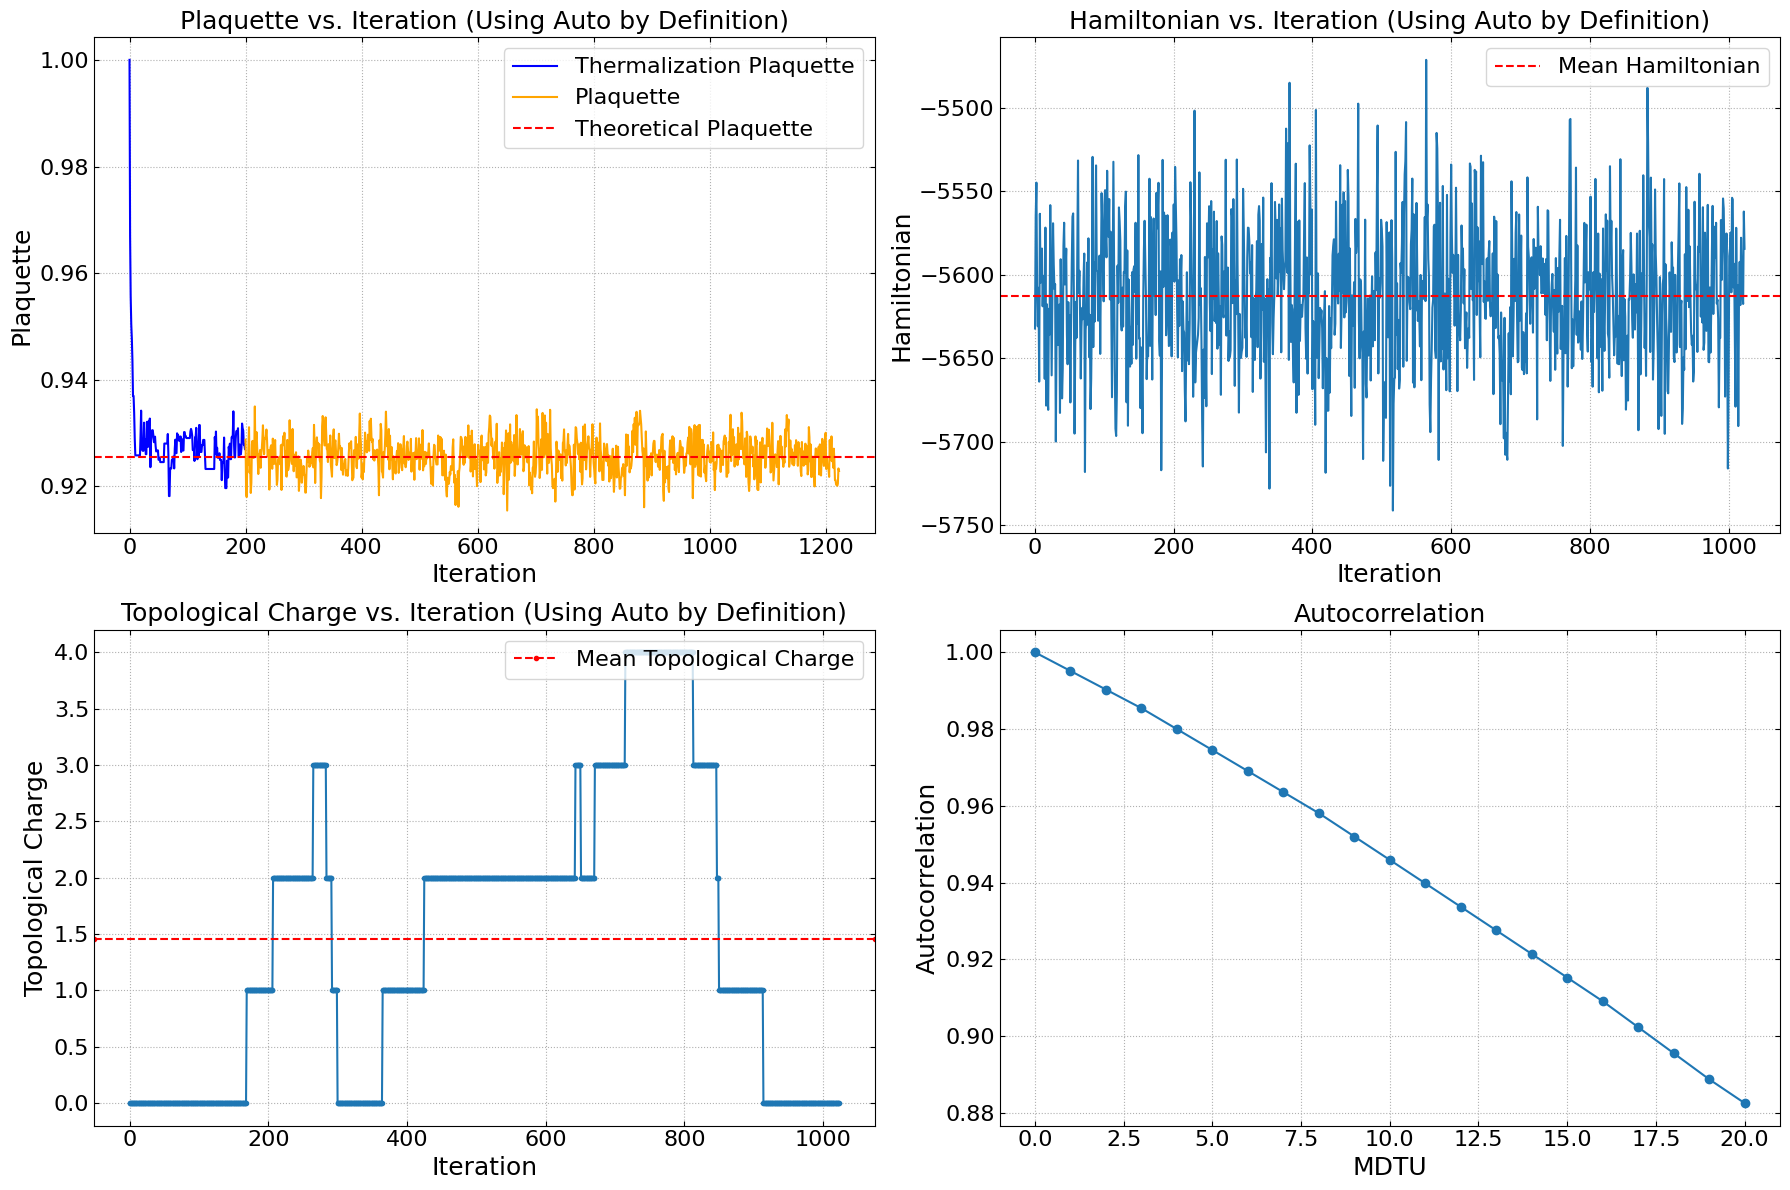

>>> Theoretical plaquette:  0.9255322107941516
>>> Mean plaq:  0.9256876858999021
>>> Std of mean plaq:  0.00010080769218371705
Thermalization acceptance rate: 0.5850
Acceptance rate: 0.5998


In [3]:
print(">>> No Field Transformation HMC Simulation: ")

# Initialize HMC
hmc = HMC_U1(lattice_size, beta, n_thermalization_steps, n_steps, step_size, device=device)

# Thermalize the system
theta_thermalized, therm_plaq_ls, therm_acceptance_rate = hmc.thermalize()

# Run HMC without field transformation
config_ls, plaq_ls, acceptance_rate, topological_charges, hamiltonians = hmc.run(n_iterations, theta_thermalized, store_interval)

print(">>> Simulation completed")


# Compute autocorrelation of topological charges
max_lag = 20
hmc_fig = hmc_summary(beta, max_lag, volume, therm_plaq_ls, plaq_ls, topological_charges, hamiltonians, therm_acceptance_rate, acceptance_rate)
hmc_fig.savefig(f'plots/hmc_L{lattice_size}_beta{beta}.pdf', transparent=True)


### Neural Network Field Transformation

>>> Neural Network Field Transformation HMC Simulation: 


/home/jinchen/miniconda3/envs/lat/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


>>> Loading the trained models
Loaded best models from epoch 15 with loss 1.647719
>>> Models loaded successfully


Running HMC: 100%|██████████| 1024/1024 [41:02<00:00,  2.40s/it]


>>> Simulation completed


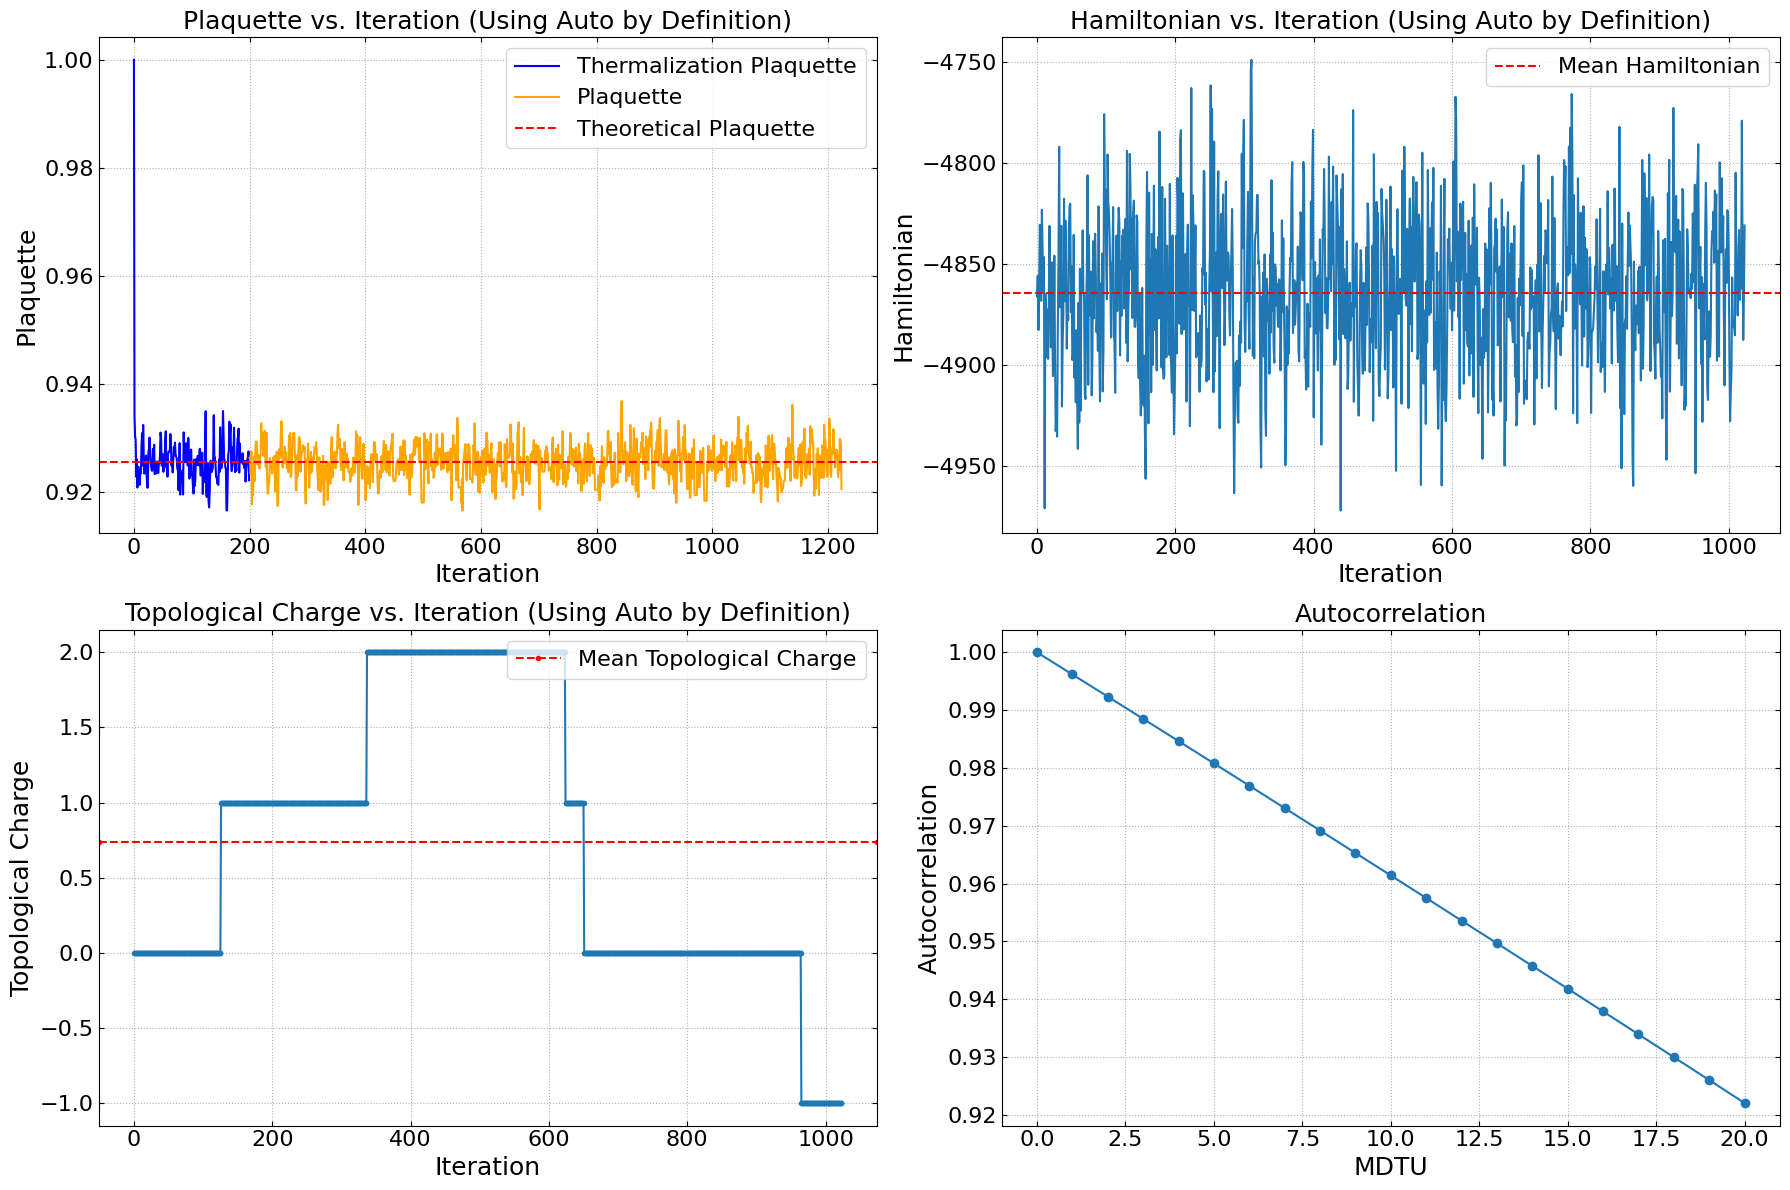

>>> Theoretical plaquette:  0.9255322107941516
>>> Mean plaq:  0.9253353048698045
>>> Std of mean plaq:  0.00010381317160516632
Thermalization acceptance rate: 0.9150
Acceptance rate: 0.8633


In [ ]:
print(">>> Neural Network Field Transformation HMC Simulation: ")

# initialize the field transformation
nn_ft = FieldTransformation(lattice_size, device=device, n_subsets=8, if_check_jac=False) #todo

# Load the trained models
print(">>> Loading the trained models")
nn_ft._load_best_model(train_beta=7)
print(">>> Models loaded successfully")

field_transformation = nn_ft.field_transformation
compute_jac_logdet = nn_ft.compute_jac_logdet

# Initialize HMC with field transformation
n_steps = 50
step_size = 0.08
store_interval = 5
n_iterations = store_interval * 1024

hmc = HMC_U1_FT(lattice_size, beta, n_thermalization_steps, n_steps, step_size, field_transformation=field_transformation, compute_jac_logdet=compute_jac_logdet, device=device)

# Thermalize the system
theta_thermalized, therm_plaq_ls, therm_acceptance_rate = hmc.thermalize()

# Run HMC without field transformation
final_config, plaq_ls, acceptance_rate, topological_charges, hamiltonians = hmc.run(n_iterations, theta_thermalized, store_interval)

print(">>> Simulation completed")

# Compute autocorrelation of topological charges
max_lag = 20
hmc_fig = hmc_summary(beta, max_lag, volume, therm_plaq_ls, plaq_ls, topological_charges, hamiltonians, therm_acceptance_rate, acceptance_rate)
hmc_fig.savefig(f'plots/hmc_ft_L{lattice_size}_beta{beta}.pdf', transparent=True)
